# GPT-2 model from scratch

## Setup

##### Config

In [1]:
import torch
import torch.nn as nn

In [2]:
# GPT2-small configuration (124M parameters)
GPT_CONFIG_124M = {
    "vocab_size": 50257, # Byte pair encoding (BPE) tokenizer
    "context_length": 256, # Max input to model
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False # No Biases in attention Head
}

##### Model

In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads  # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)  # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)  # optional projection

        return context_vec

In [4]:
class GPT2(nn.Module):
  def __init__(self, config):
    super().__init__()
    # Look up table from token (word) to associated embedding
    self.token_emb = nn.Embedding(config["vocab_size"], config["emb_dim"])
    self.pos_emb = nn.Embedding(config["context_length"], config["emb_dim"])
    self.drop_emb = nn.Dropout(config["drop_rate"])

    # Multi attention head
    self.transformer_blocks = nn.Sequential(
        *[TransformerBlock(config) for _ in range(config["n_layers"])]
    )

    self.final_layer_norm = LayerNorm(config["emb_dim"])
    self.out_head = nn.Linear(
        config["emb_dim"], config["vocab_size"], bias=False
    )


  def forward(self, in_index):
    batch_size, seq_len = in_index.shape
    token_emb = self.token_emb(in_index)
    pos_emb = self.pos_emb(torch.arange(seq_len, device=in_index.device))

    x = token_emb + pos_emb
    x = self.drop_emb(x)
    x = self.transformer_blocks(x)
    x = self.final_layer_norm(x)
    logits = self.out_head(x)

    return logits


class TransformerBlock(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.att = MultiHeadAttention(
        d_in=config["emb_dim"], d_out=config["emb_dim"], context_length=config["context_length"],
        dropout=config["drop_rate"], num_heads=config["n_heads"], qkv_bias=config["qkv_bias"]
    )
    self.feedforward = FeedForward(config)
    self.norm1 = LayerNorm(config["emb_dim"])
    self.norm2 = LayerNorm(config["emb_dim"])
    self.drop_shortcut = nn.Dropout(config["drop_rate"])

  def forward(self, x):
    shortcut = x
    x = self.norm1(x)
    x = self.att(x)
    x = self.drop_shortcut(x)
    x = x + shortcut

    shortcut = x
    x = self.norm2(x)
    x = self.feedforward(x)
    x = self.drop_shortcut(x)
    x = x + shortcut

    return x


class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
      super().__init__()
      self.eps = 1e-5
      self.scale = nn.Parameter(torch.ones(emb_dim))
      self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self, x):
      mean = x.mean(dim=-1, keepdim=True)
      var = x.var(dim=-1, keepdim=True, unbiased=False)
      norm_x = (x - mean) / torch.sqrt(var + self.eps)
      return self.scale * norm_x + self.shift


class GELU(nn.Module):
  def __init__(self):
      super().__init__()

  def forward(self, x):
      return 0.5 * x * (1 + torch.tanh(
          torch.sqrt(torch.tensor(2.0 / torch.pi)) *
          (x + 0.044715 * torch.pow(x, 3))
      ))


class FeedForward(nn.Module):
  def __init__(self, cfg):
      super().__init__()
      self.layers = nn.Sequential(
          nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
          GELU(),
          nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
      )

  def forward(self, x):
      return self.layers(x)




## Run the model

In [5]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2") # BPE encoder

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [6]:
torch.manual_seed(123)
model = GPT2(GPT_CONFIG_124M)

logits = model(batch)
print(f"Input batch:\n {batch}")
print(f"Output shape: {logits.shape}")
print(logits)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.7955e-01,  2.8515e-01, -7.6131e-01,  ..., -4.8374e-01,
          -4.2503e-01, -1.7187e-01],
         [-6.2581e-01, -3.7480e-01, -9.7020e-01,  ...,  1.9168e-01,
          -1.3234e+00, -2.7643e-01],
         [ 5.1744e-01,  1.3866e-01,  2.4886e-01,  ...,  3.5054e-01,
          -7.7531e-02, -8.0041e-02],
         [-2.5664e-01, -6.9693e-01, -9.9479e-01,  ..., -4.4731e-02,
           6.1772e-02,  1.3467e-01]],

        [[-2.2379e-01,  1.1651e-01, -9.9836e-01,  ..., -1.5730e-01,
          -4.4800e-01, -2.8647e-02],
         [-8.7227e-01, -3.9389e-01, -1.1099e+00,  ...,  3.3035e-01,
          -9.2394e-02, -1.8369e-05],
         [ 4.5988e-01, -1.4274e-01, -1.2227e-01,  ...,  2.7490e-01,
           5.8296e-02, -8.9931e-02],
         [-6.2163e-01, -4.4854e-01, -4.7675e-01,  ..., -3.6519e-01,
           3.4402e-01, -3.8154e-01]]], grad_fn=<UnsafeViewBackward0>)


In [7]:
total_params = sum(p.numel() for p in model.parameters())
# Note: 163M params instead of 124M, because in practice token embedding layer is reused for last output layer
print(f"total parameters: {total_params:,}")

total parameters: 162,419,712


# Working

### Normalization

In [8]:
import torch
import torch.nn as nn

torch.manual_seed(123)

# 2 train example of dim 5
batch_example = torch.rand(2, 5)

layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

# calculate mean and variance
mean = out.mean(dim=1, keepdim=True)
var = out.var(dim=1, keepdim=True)

print(f"Mean:\n {mean}")
print(f"Var:\n {var}")

# normalize output
out_norm = (out - mean) / torch.sqrt(var)
print("Normalized layer outputs:\n", out_norm)

tensor([[0.0000, 0.0000, 0.4091, 0.6587, 0.3914, 0.0000],
        [0.0000, 0.0000, 0.1902, 0.3182, 0.6486, 0.0000]],
       grad_fn=<ReluBackward0>)
Mean:
 tensor([[0.2432],
        [0.1928]], grad_fn=<MeanBackward1>)
Var:
 tensor([[0.0799],
        [0.0670]], grad_fn=<VarBackward0>)
Normalized layer outputs:
 tensor([[-0.8603, -0.8603,  0.5869,  1.4698,  0.5242, -0.8603],
        [-0.7450, -0.7450, -0.0102,  0.4844,  1.7608, -0.7450]],
       grad_fn=<DivBackward0>)


### GELU

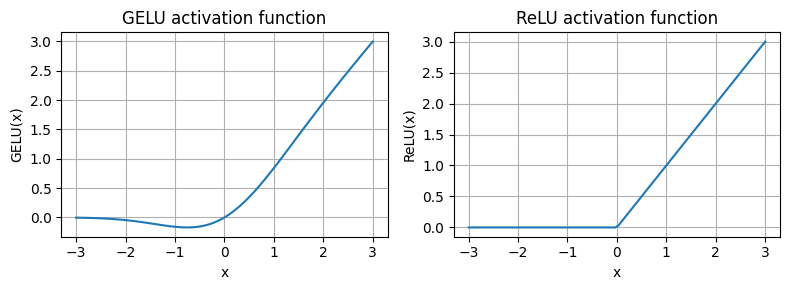

In [9]:
import matplotlib.pyplot as plt


class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(
        torch.sqrt(torch.tensor(2.0 / torch.pi)) *
        (x + 0.044715 * torch.pow(x, 3))
    ))


gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

# Generate text

In [8]:
def generate_text_simple(model, index, max_new_tokens, context_length):
    # index is (batch, n_tokens) array of indices in current context
    for _ in range(max_new_tokens):
        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10, then only the last 5 tokens are used as context
        index_cond = index[:, -context_length:]

        # Predict
        with torch.no_grad():
            logits = model(index_cond)

        # Focus only on the last time step (of the token)
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]  

        # Apply softmax to get probabilities
        probs = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the index of the vocab entry with the highest probability value
        index_next = torch.argmax(probs, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        index = torch.cat((index, index_next), dim=1)  # (batch, n_tokens+1)

    return index

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    # Unsqueeze add extra dim at 0, essentially adding a batch dim
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())


start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    index=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_length=GPT_CONFIG_124M["context_length"]
)

print(f"Output text:\n {token_ids_to_text(token_ids, tokenizer)}")

Output text:
 Every effort moves you Laur similarity motivated squarelylierordered Crimes deviationsMadenas


#### Train the model

In [9]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

with torch.no_grad():
    logits = model(inputs)

probs = torch.softmax(logits, dim=-1)
print(probs.shape)

token_ids = torch.argmax(probs, dim=-1, keepdim=True)
print(f"Token IDs:\n {token_ids}")

print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

torch.Size([2, 3, 50257])
Token IDs:
 tensor([[[36195],
         [31786],
         [44376]],

        [[49906],
         [15335],
         [41751]]])
Targets batch 1:  effort moves you
Outputs batch 1: lifhetically inaction


In [10]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

# Download and load the content of 'the-verdict' book as text_data
if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode("utf-8")
    with open(file_path, 'w', encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()


total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [11]:
from DataLoader import create_dataloader_v1

train_ratio = 0.90
split_index = int(train_ratio * len(text_data))
train_data = text_data[:split_index]
val_data = text_data[split_index:]

torch.manual_seed(123)

train_loader = create_dataloader_v1(
    txt=train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    txt=val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)


# Sanity Check
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")
    
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [12]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using {device} device")
model.to(device)
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print(f"Training loss: {train_loss}")
print(f"Validation loss: {val_loss}")


Using mps device
Training loss: 10.989404254489475
Validation loss: 10.981025695800781


In [13]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_length = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, index=encoded,
            max_new_tokens=50, context_length=context_length
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()


# Start training
import time
start_time = time.time()


torch.manual_seed(123)
model = GPT2(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")


Ep 1 (Step 000000): Train loss 9.817, Val loss 9.924
Ep 1 (Step 000005): Train loss 8.066, Val loss 8.332
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.619, Val loss 7.042
Ep 2 (Step 000015): Train loss 6.046, Val loss 6.596
Every effort moves you, and,, and, and,,,,, and, and,,,,,,,,,,, and,, the,, the, and,, and,,, the, and,,,,,,
Ep 3 (Step 000020): Train loss 5.524, Val loss 6.508
Ep 3 (Step 000025): Train loss 5.369, Val loss 6.378
Every effort moves you, and to the of the of the picture. Gis.                                     
Ep 4 (Step 000030): Train loss 4.830, Val loss 6.263
Ep 4 (Step 000035): Train loss 4.586, Val loss 6.285
Every effort moves you of the "I the picture.                    "I"I the picture"I had the picture"I the picture and I had been the picture of
Ep 5 (Step 000040): Train loss 3.879, Val loss 6.130
Every effort moves you know he had been his pictures, and I felt it's by his last word.          

#### Temperature Scaling (Add Randomness)

forward


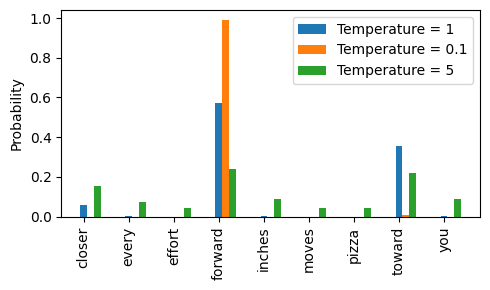

In [14]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 

inverse_vocab = {v: k for k, v in vocab.items()}

# Suppose input is "every effort moves you", and the LLM
# returns the following logits for the next token:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()

# The next generated token is then as follows:
print(inverse_vocab[next_token_id])

# ------------------------------------------------------------------
# Higher temperature, more randomness; Lower temperature, less randomness
temperatures = [1, 0.1, 5]

def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

# Plot
import matplotlib.pyplot as plt

x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

#### Top k-sampling (Introduce Diversity)

In [15]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)

print("Top logits:", top_logits)
print("Top positions:", top_pos)

new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float("-inf")), 
    other=next_token_logits
)

print(new_logits)


Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])
tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


#### Modified Generate Text

In [ ]:
def generate(model, idx, max_new_tokens, context_length, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_length:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx


torch.manual_seed(123)
model = model.to(device)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=15,
    context_length=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 What is the state of the trade war between US and China treacherous g consist conduassiumparticip hairscooked Ir Zig Twin famous cannibal Transate


#### Save Model Parameters

In [17]:
# Specify optimizer to be AdamW, over regular SGD or Adam
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    }, 
    "model_and_optimizer.pth"
)


# If we want to load it back
model = GPT2(GPT_CONFIG_124M)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("model.pth", map_location=device, weights_only=True))
model.eval()

FileNotFoundError: [Errno 2] No such file or directory: 'model.pth'